### -

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils import *
from classes import *
from train_models import *

import json
with open('config.json', 'r') as f:
    CONFIG = json.load(f)

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
color_palette = sns.color_palette("viridis_r", as_cmap=True)
rates_array = np.array(range(0,96,5))*0.01

- **Versões:**
  - v0: Versão inicial. Sem assessores. Apenas cálculo de confiança para rejeição por meio da probabilidade de classe dos modelos.

# TWO MOONS

In [3]:
dataset_name = 'twomoons'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/966428553990272344', creation_time=1765751818487, experiment_id='966428553990272344', last_update_time=1765751818487, lifecycle_stage='active', name='twomoons_v2.5_1246495320', tags={}>

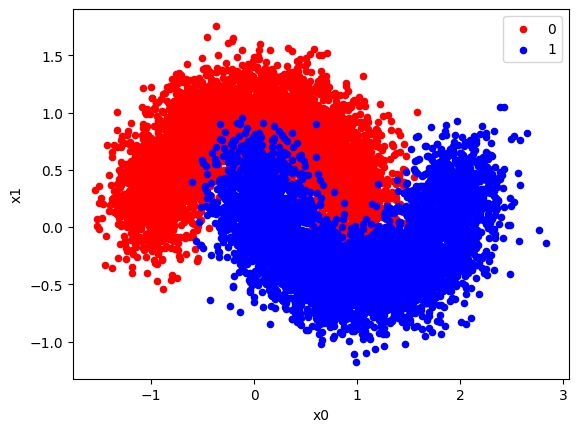

In [4]:
# generate 2d classification dataset
X, y = make_moons(n_samples=CONFIG['TWO_MOONS']['N_SAMPLES'], 
                  noise=CONFIG['TWO_MOONS']['NOISE'], 
                  random_state=CONFIG['SEED'])
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [6]:
models, metades = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
X_train, X_val, X_test, y_train, y_val, y_test, scaler = get_data(dataset_name)
pred_reject = Pool(models)

ce43069e02e74bddad51cd7d5b192edb


d2193522c64e4e4784a58264954b2b92


5fda025358e24b41977d0df21f67a0df


39f9910cf1794706b47cd793739d4983


e7411e4b0eb5435fb18022493fd8499f


a10794ba3a294e40a3b5d11242743a22


e7f6da519c2345f2969c02a8d3f65043


407d9f20a6c246709b4370dc526f3459


be4aa591cb304d4aa290da54738f81f5


c5729c17116a418588613e386a4336f9


64911773406843cb837771154ffde422


1540bfda2f44444ea793bf5a9ed48439


a732148237284f728785387b3884e810


In [ ]:
results_log, reject_history = rejection_overhall(pred_reject, # tenho que refazer o treinamento para esses casos
                                                 X_test,#[:1500],
                                                 y_test,#[:1500],
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing:   0%|          | 0/84 [00:00<?, ?it/s]


AttributeError: 'SpecificScaler' object has no attribute 'all_features_'

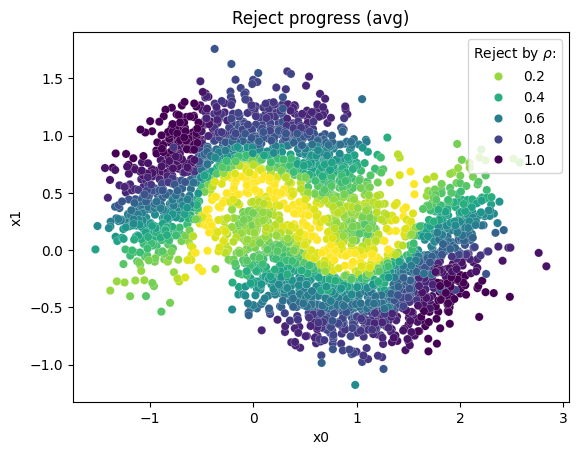

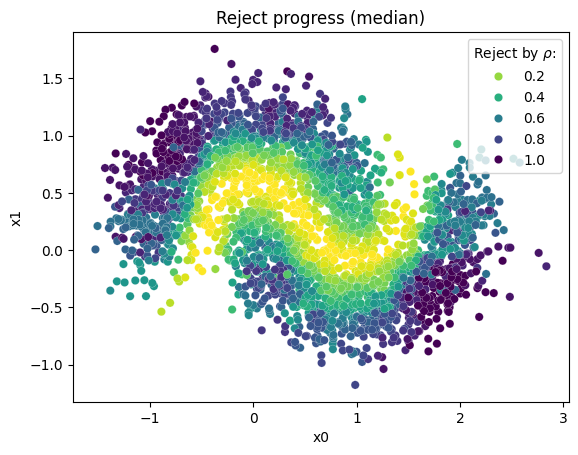

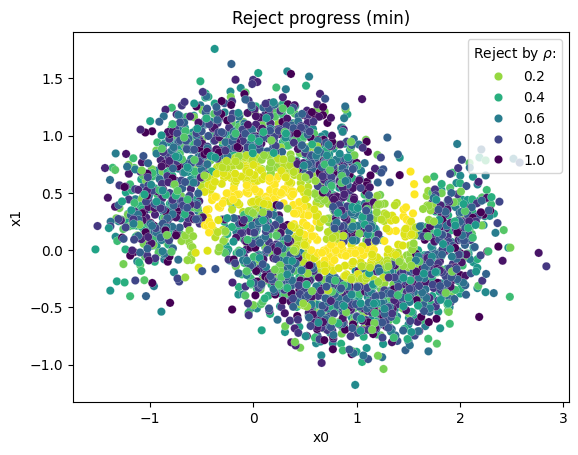

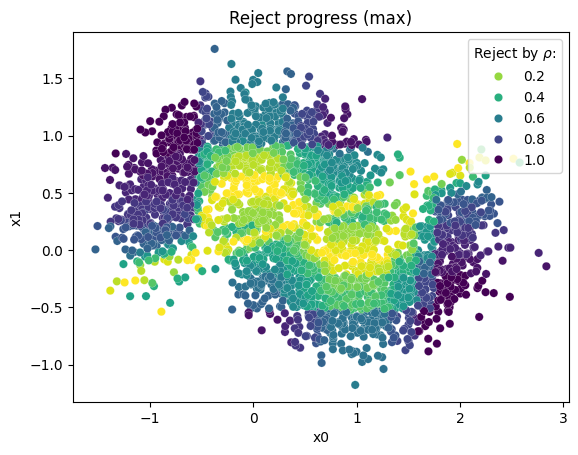

In [7]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

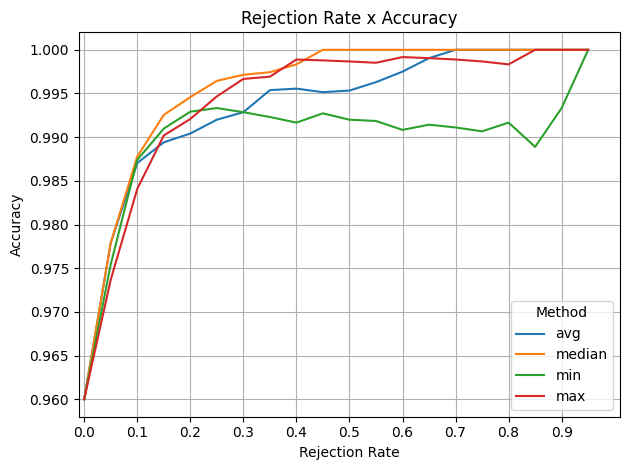

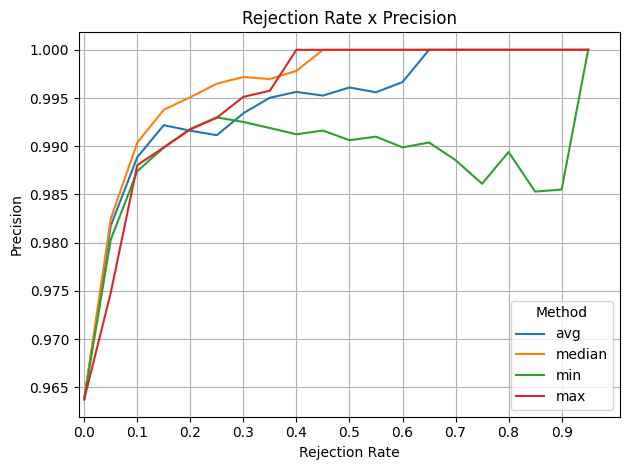

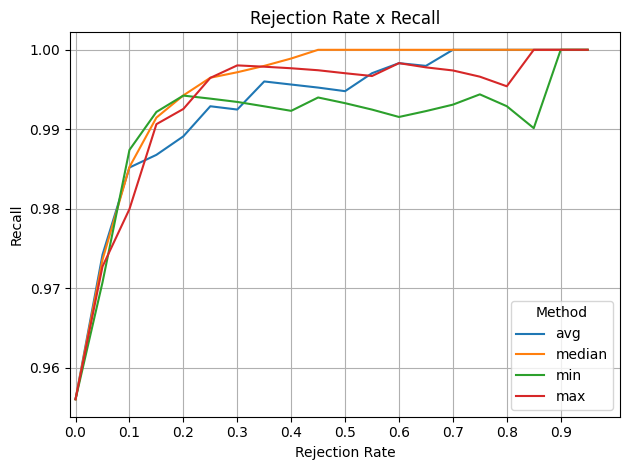

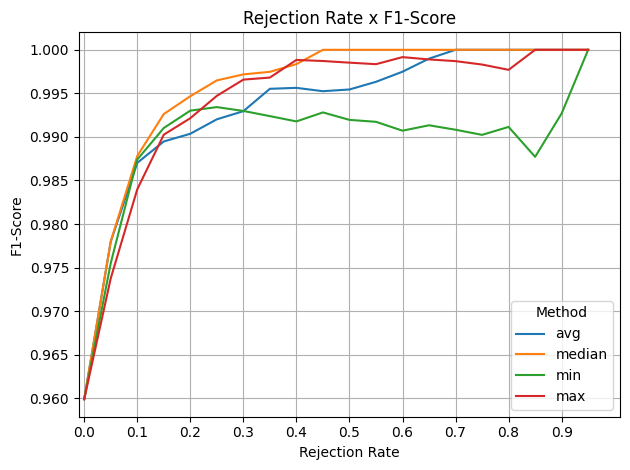

In [8]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.944
Method: median 	 |  Score: 0.946
Method: min 	 |  Score: 0.941
Method: max 	 |  Score: 0.945


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.960000   0.963758  0.956059  0.959893  0.944194
1     avg            0.05  0.977895   0.981754  0.974234  0.977980  0.944194
2     avg            0.10  0.987037   0.988856  0.985196  0.987023  0.944194
3     avg            0.15  0.989412   0.992188  0.986791  0.989482  0.944194
4     avg            0.20  0.990417   0.991611  0.989121  0.990364  0.944194
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.998667   1.000000  0.996622  0.998308  0.944863
76    max            0.80  0.998333   1.000000  0.995413  0.997701  0.944863
77    max            0.85  1.000000   1.000000  1.000000  1.000000  0.944863
78    max            0.90  1.000000   1.000000  1.000000  1.000000  0.944863
79    max            0.95  1.000000   1.000000  1.000000  1.000000  0.944863

[80 rows x 7 columns]

In [10]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# CIRCLES

In [11]:
dataset_name = 'circles'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/885427544680083922', creation_time=1764373625193, experiment_id='885427544680083922', last_update_time=1764373625193, lifecycle_stage='active', name='circles_v1_1246495320', tags={}>

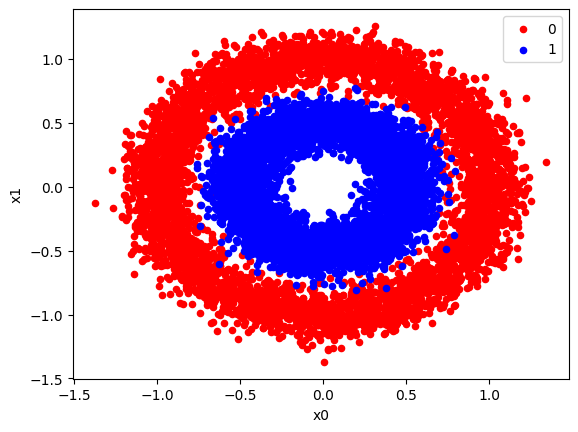

In [12]:
X, y = make_circles(n_samples=int(CONFIG['CIRCLES']['N_SAMPLES']/1), 
                            noise=CONFIG['CIRCLES']['NOISE'], 
                            factor=CONFIG['CIRCLES']['FACTOR'],
                            random_state=CONFIG['SEED'])

df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [13]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

089b7697350e4362a15285737b9536ec


9cc9b134f6e1400faa44a311eedf575e


7e32fd71066048d4b288716e63299882


1d6de1ea381e49d4b96525bb47117d29


c63125d0f9a14fa081b6aefc1892dce9


fe0a3881374d47e2abd3f3b5d31bcc50


6f6c64d5095142f3a63e7c0d1d22f29b


eaa70f433b9a4fce9c7363dca8a14ee0

020c36aaf2664947aee192ad7d031e6e


d44950dcf16d4d44adb218fe621befde


e7fc2b33733142b0af945ec0071e3d8a


ecf3b7a372804bd5ab079fb44a4e4410


In [14]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,#[:500],
                                                 y_test,#[:500],
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:13<00:00,  6.29it/s, Method=max, Rate=1.00]   


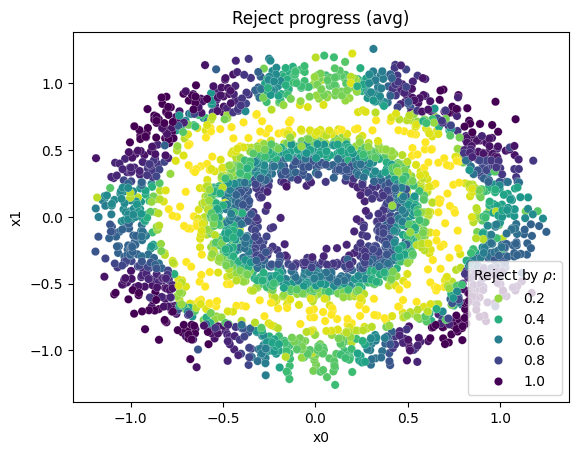

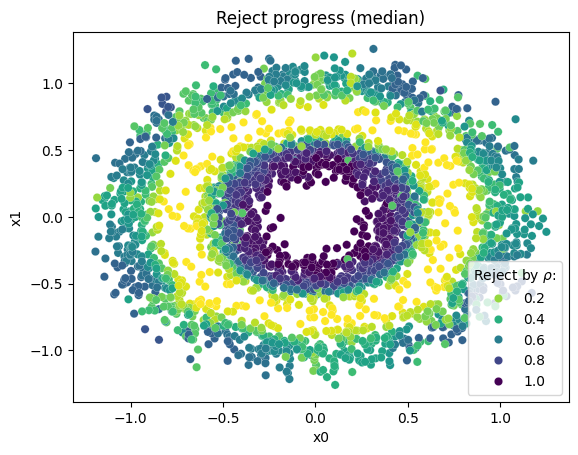

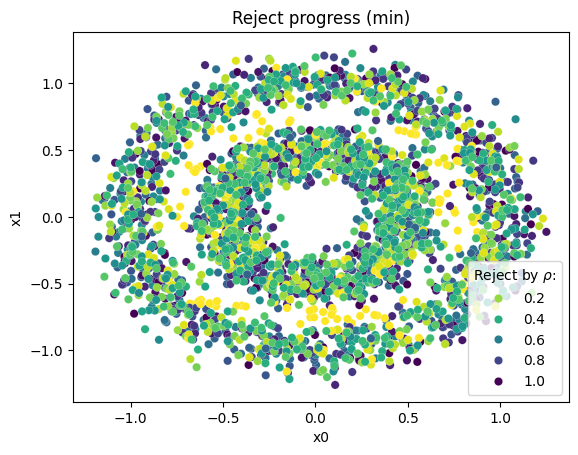

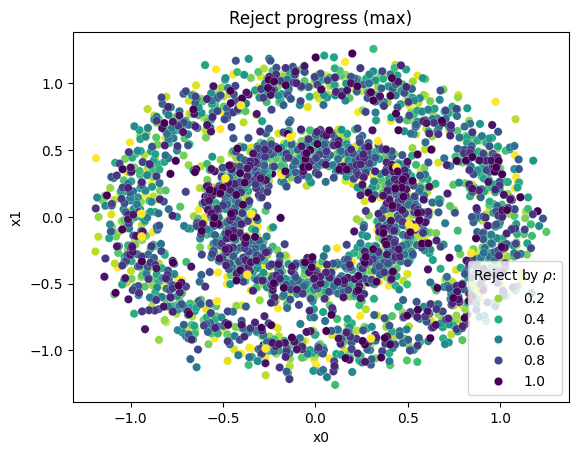

In [15]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste, x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

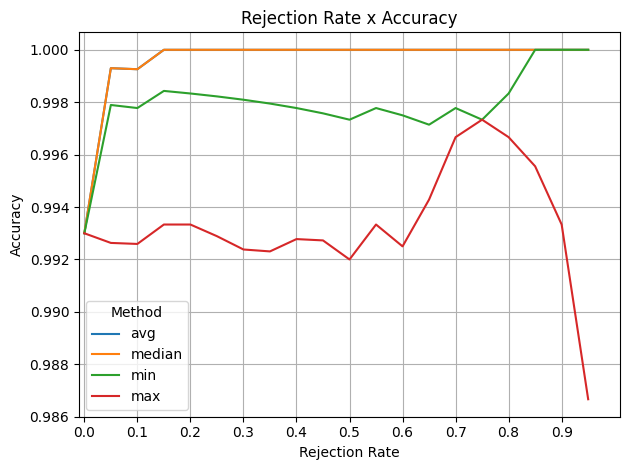

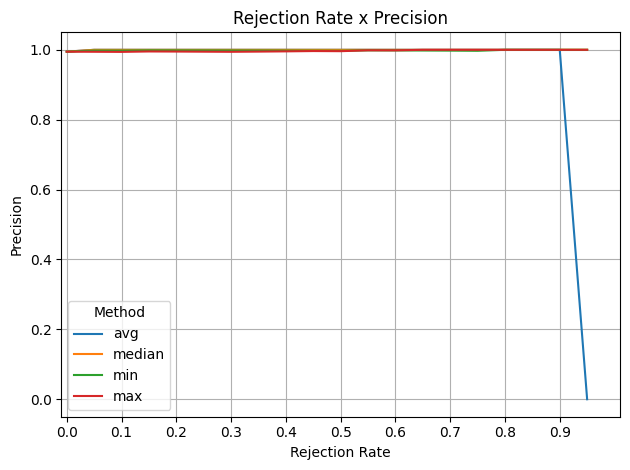

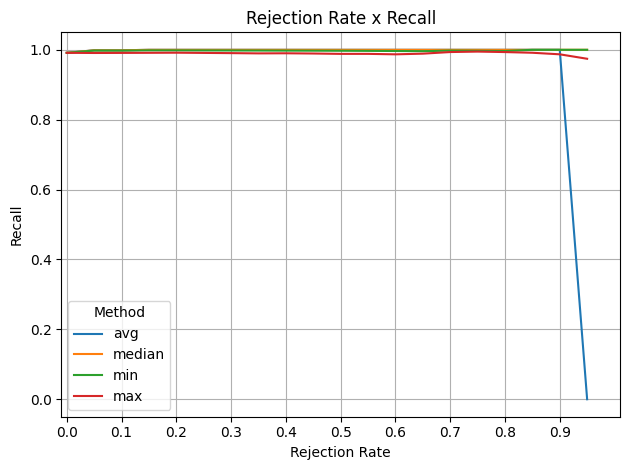

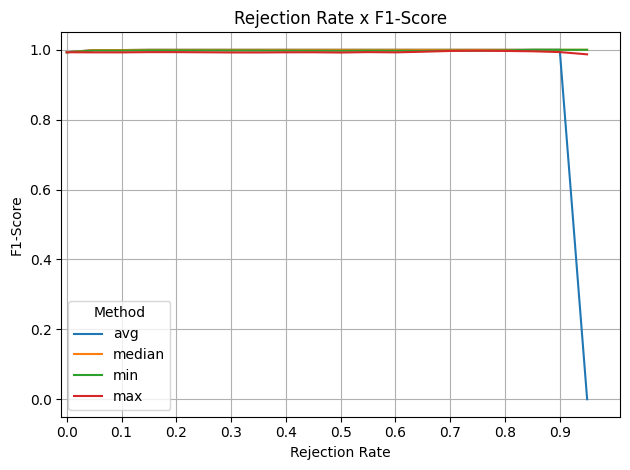

In [16]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.948
Method: max 	 |  Score: 0.944


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.993000   0.994656  0.991345  0.992998  0.949753
1     avg            0.05  0.999298   1.000000  0.998598  0.999299  0.949753
2     avg            0.10  0.999259   1.000000  0.998514  0.999257  0.949753
3     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.949753
4     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.949753
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.997333   1.000000  0.994885  0.997436  0.943824
76    max            0.80  0.996667   1.000000  0.993528  0.996753  0.943824
77    max            0.85  0.995556   1.000000  0.991561  0.995763  0.943824
78    max            0.90  0.993333   1.000000  0.987097  0.993506  0.943824
79    max            0.95  0.986667   1.000000  0.974359  0.987013  0.943824

[80 rows x 7 columns]

In [ ]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# AIRBNB

In [19]:
dataset_name = 'airbnb'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/783103757422631956', creation_time=1764375195411, experiment_id='783103757422631956', last_update_time=1764375195411, lifecycle_stage='active', name='airbnb_v1_1246495320', tags={}>

In [20]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name)
pred_reject = Pool(models)

f15e5fa2a18e47388fc7a529df093969


c6abba731b7d4312a448fb8c2f559be3


257a5f89fef744e8b718bb61d8be2a90


6a7287e39c524402ae630e4c4d67d21e


a2c39c04a7e0451c9b29ba59fdf9e937


86fd632cf103477788688a710f94c799


1b813293e7e84d4bb9515357956868be


7b279ae3c9ed4d2f82c57202ea95d07c


b4c8e0ce382f42288cdb689fa7b67b05


6d2d341c4b1448a383875c5417473596


1c73de36830749eb94ccba25a13087af


fc1e4b1b8baf452cbb1b640493ff7fdf


In [21]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:43<00:00,  1.94it/s, Method=max, Rate=1.00]   


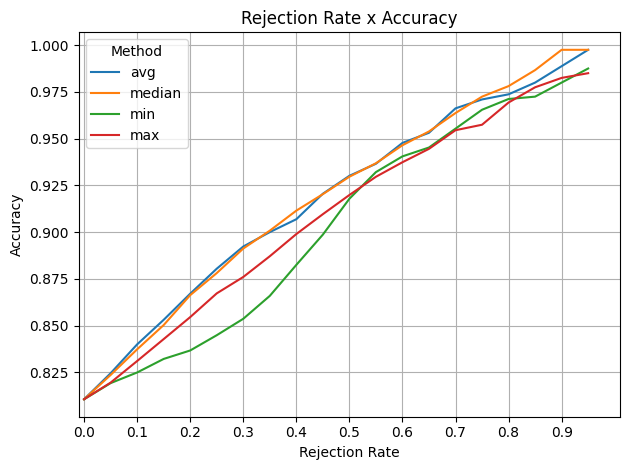

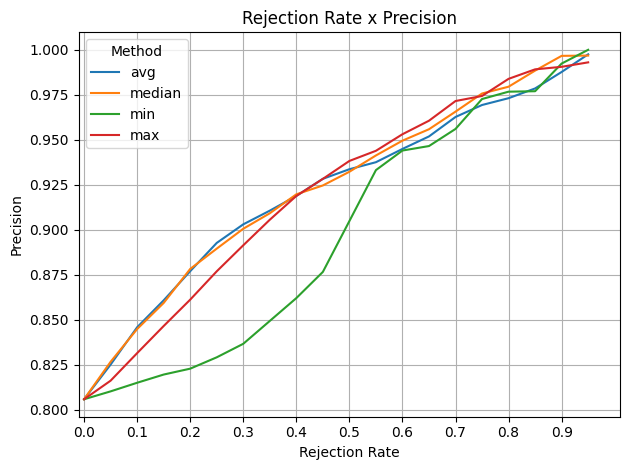

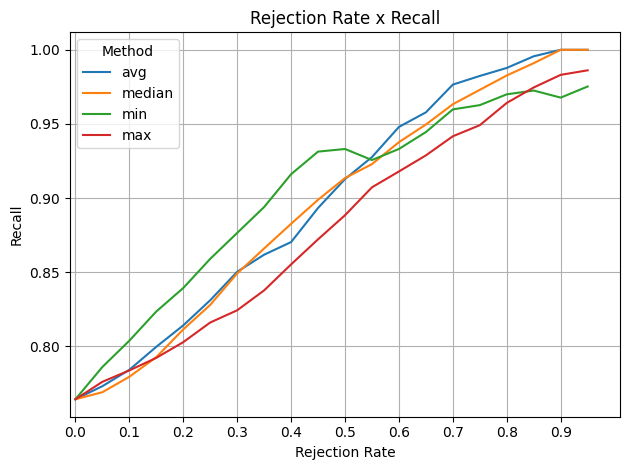

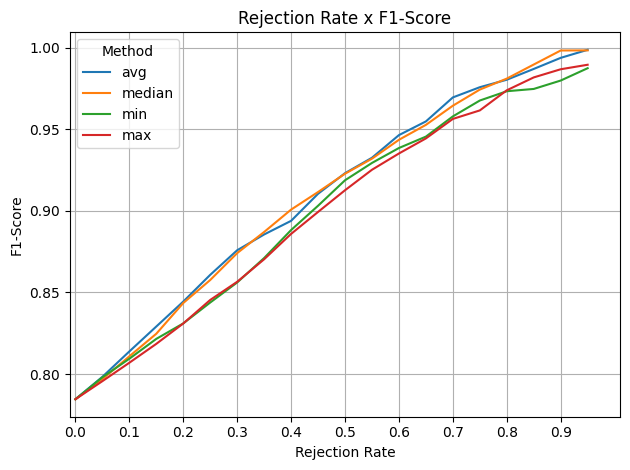

In [22]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [25]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.872
Method: median 	 |  Score: 0.872
Method: min 	 |  Score: 0.857
Method: max 	 |  Score: 0.863


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.810645   0.805913  0.764298  0.784554  0.871807
1     avg            0.05  0.824545   0.825188  0.773114  0.798303  0.871807
2     avg            0.10  0.839989   0.845895  0.784155  0.813856  0.871807
3     avg            0.15  0.853123   0.860854  0.799669  0.829135  0.871807
4     avg            0.20  0.867095   0.877046  0.814134  0.844420  0.871807
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.957436   0.974359  0.949153  0.961591  0.862870
76    max            0.80  0.969317   0.983871  0.964173  0.973922  0.862870
77    max            0.85  0.977462   0.989145  0.974599  0.981818  0.862870
78    max            0.90  0.982478   0.990548  0.983114  0.986817  0.862870
79    max            0.95  0.985000   0.993031  0.986159  0.989583  0.862870

[80 rows x 7 columns]

In [26]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# BLOBS

In [27]:
#from train_models import experiment_name
dataset_name = 'blobs'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/107733327260347162', creation_time=1764374475707, experiment_id='107733327260347162', last_update_time=1764374475707, lifecycle_stage='active', name='blobs_v1_1246495320', tags={}>

In [28]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

98e66a57611d47f0a34c5e6f589bc3c9


b376579ce547428b9ee91c0859d7eb5c


193cf6c328c04c66b7fd58caca988df8


92f4de1db427406f8ea4790c2a484473


622363b773234cfab387ea0d9d78dfa5


6e2d9b73af9d4f809456beb50198443c


9898bc9b59a543b29e1ea726b3cb6721


8ccd3f5206314c4bba01f0c055d4eac0


09d569a1b2e9492484ac58e7a7fe84a1


25de63a01dda4da180fee6b4374ac900


b9506e6109454e0d85bdf42d8597cac6


3d0a8be21b05454dbdd7bbe541437bba


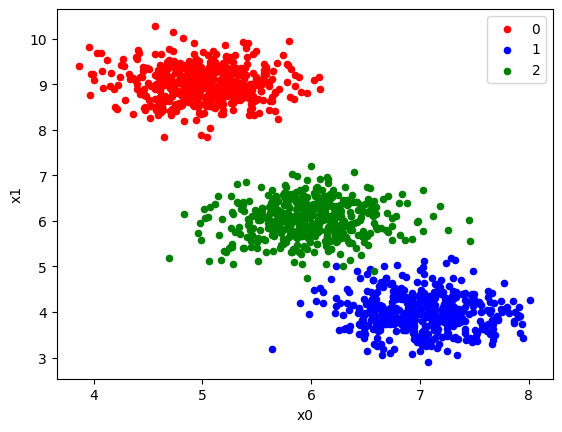

In [29]:
df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [30]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:06<00:00, 13.08it/s, Method=max, Rate=1.00]   


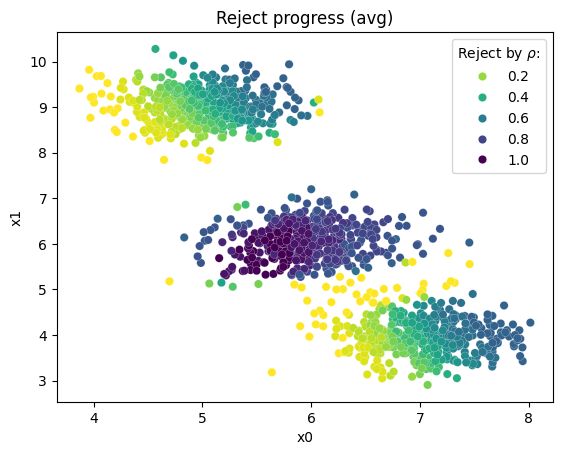

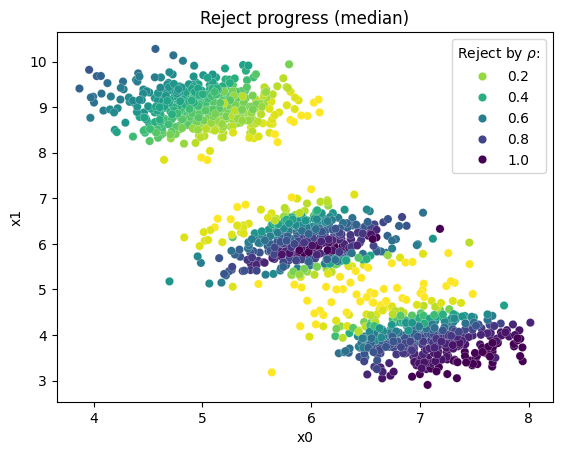

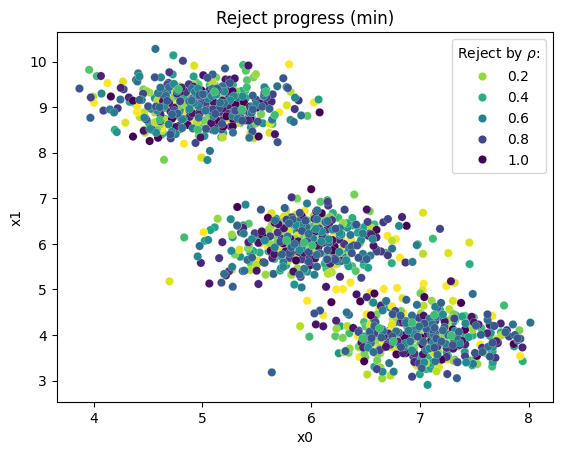

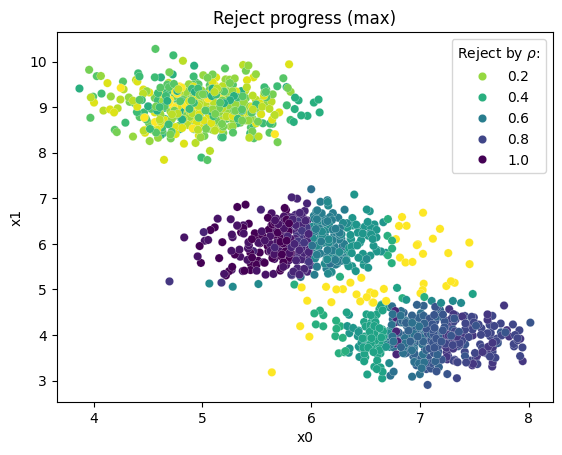

In [31]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

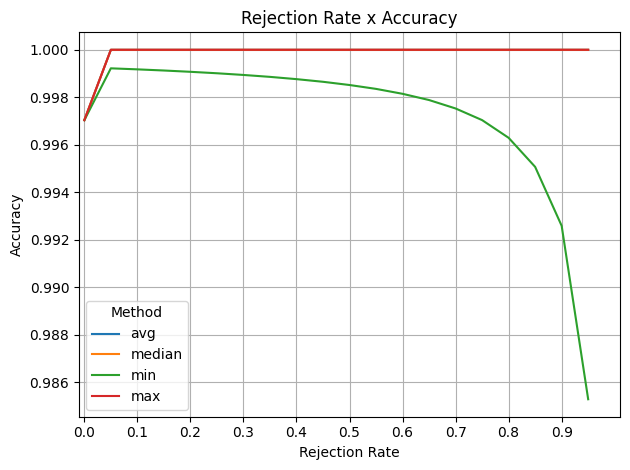

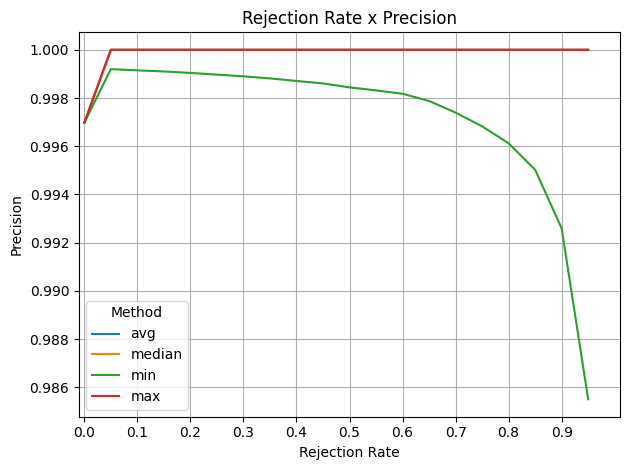

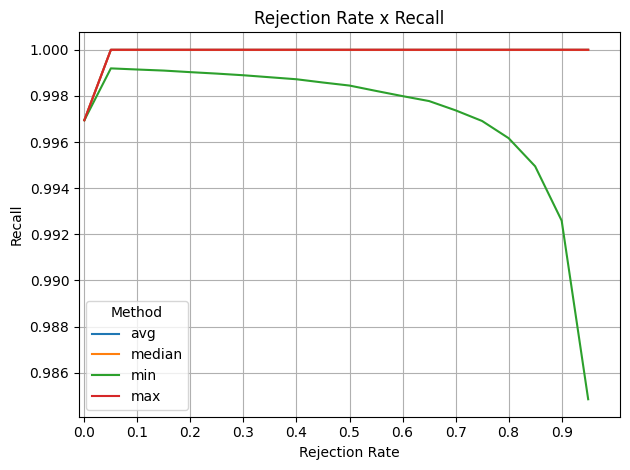

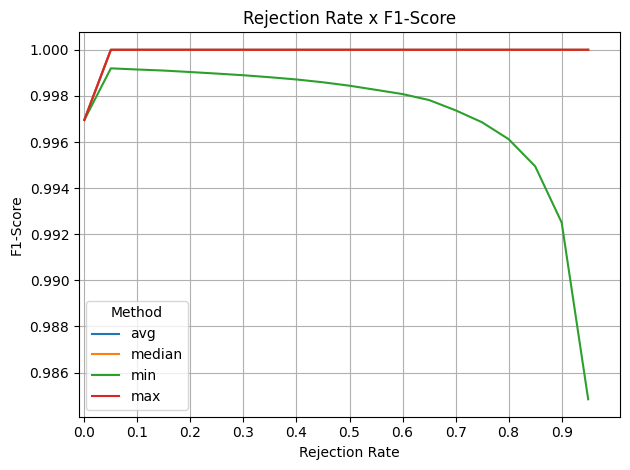

In [32]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [33]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.948
Method: max 	 |  Score: 0.950


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.997037   0.996973  0.996945  0.996956  0.949926
1     avg            0.05  1.000000   1.000000  1.000000  1.000000  0.949926
2     avg            0.10  1.000000   1.000000  1.000000  1.000000  0.949926
3     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.949926
4     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.949926
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  1.000000   1.000000  1.000000  1.000000  0.949926
76    max            0.80  1.000000   1.000000  1.000000  1.000000  0.949926
77    max            0.85  1.000000   1.000000  1.000000  1.000000  0.949926
78    max            0.90  1.000000   1.000000  1.000000  1.000000  0.949926
79    max            0.95  1.000000   1.000000  1.000000  1.000000  0.949926

[80 rows x 7 columns]

In [34]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# ANISO

In [35]:
dataset_name = 'aniso'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/363564732637628297', creation_time=1764374178156, experiment_id='363564732637628297', last_update_time=1764374178156, lifecycle_stage='active', name='aniso_v1_1246495320', tags={}>

In [36]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

6c1b5010ba49412488515d74d698faef


9290cad6e925441fbe9d0ef4ed569cf4


1c7a11c3e26243b49d7b08b2ff1b39cd


c6bd39dcd796410b8adfc3a1e321307c


c8618b8e6406479b82ecd162d488d327


14fadfd426614f4b8508d60da234ff8f


2b6c35ba9e8a4f24b073e2118418e829


2d5e391797d445ca80489aefa415441d


8c273fee954249bca8d351de380e6e78


2192597efced413b9ff03159d06eebac


282ca36cfd9c4797836646a13a339438


3d65a0d4afbd4901b101706d46d12c23


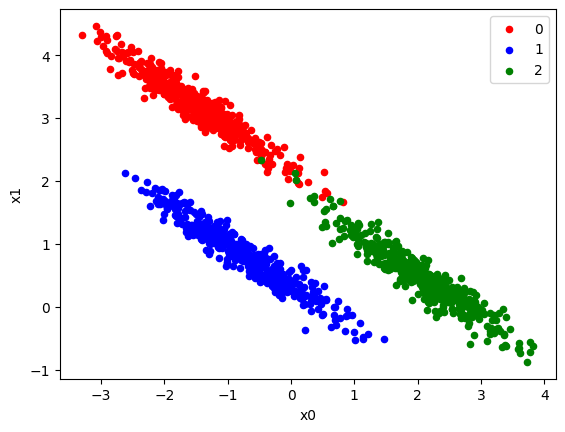

In [37]:
df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [38]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:06<00:00, 13.01it/s, Method=max, Rate=1.00]   


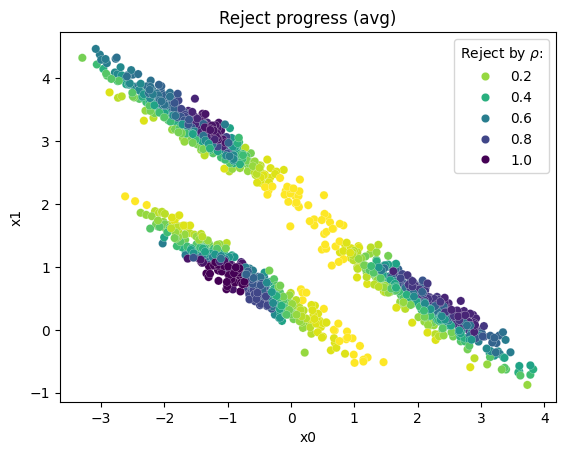

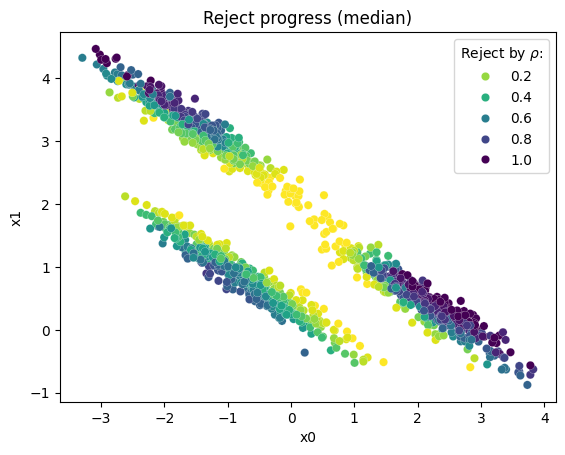

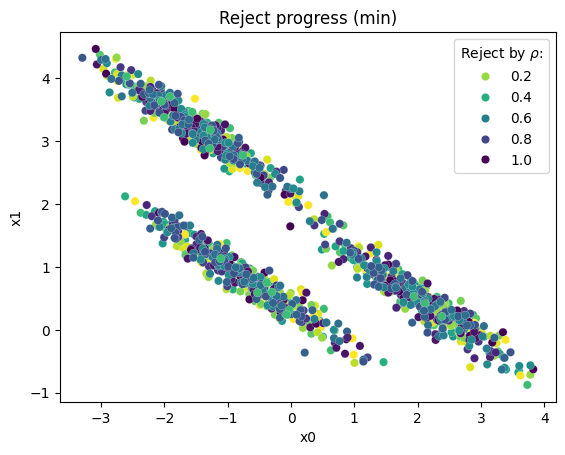

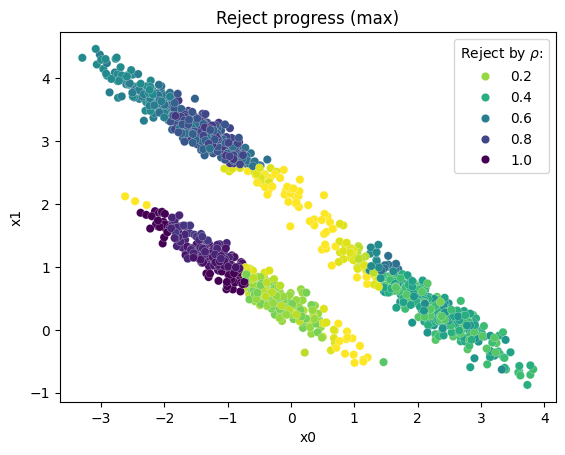

In [39]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

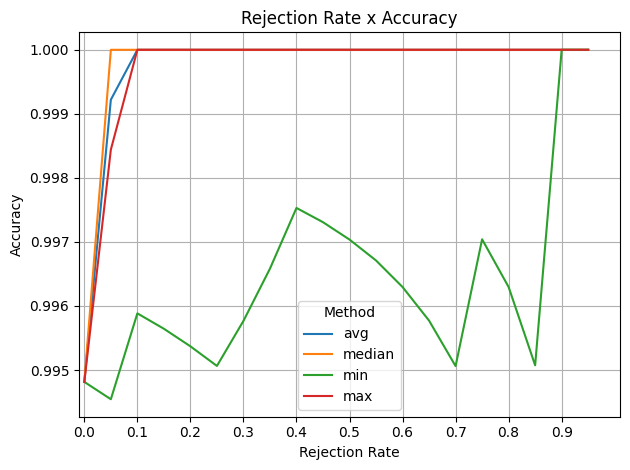

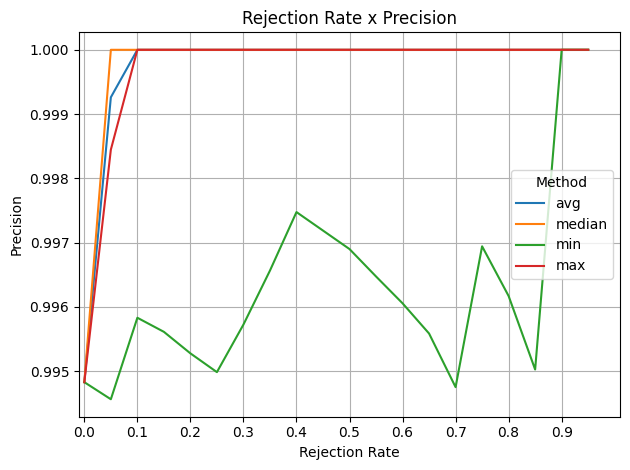

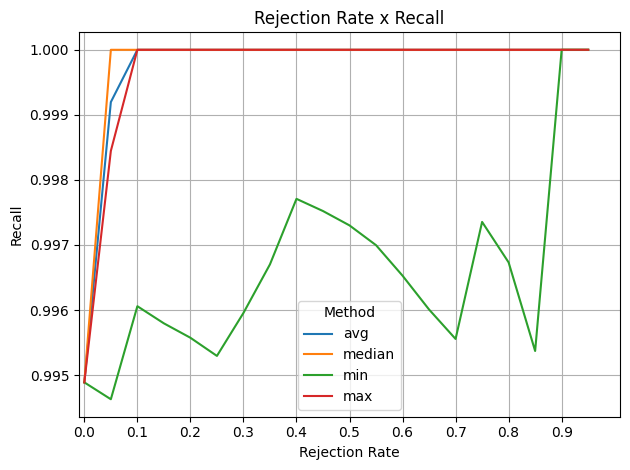

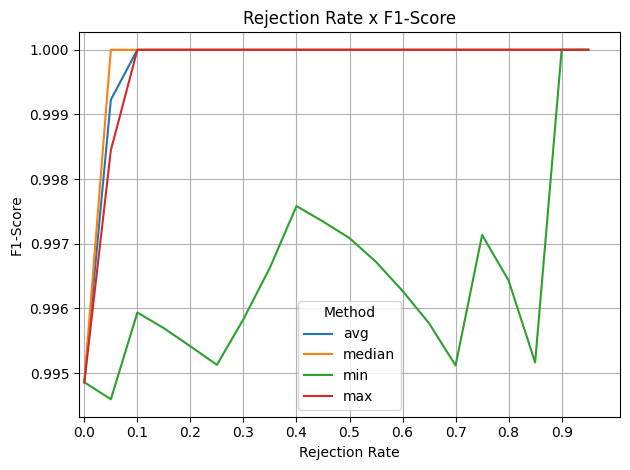

In [40]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [41]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.947
Method: max 	 |  Score: 0.950


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.994815   0.994828  0.994888  0.994857  0.949831
1     avg            0.05  0.999221   0.999261  0.999197  0.999228  0.949831
2     avg            0.10  1.000000   1.000000  1.000000  1.000000  0.949831
3     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.949831
4     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.949831
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  1.000000   1.000000  1.000000  1.000000  0.949792
76    max            0.80  1.000000   1.000000  1.000000  1.000000  0.949792
77    max            0.85  1.000000   1.000000  1.000000  1.000000  0.949792
78    max            0.90  1.000000   1.000000  1.000000  1.000000  0.949792
79    max            0.95  1.000000   1.000000  1.000000  1.000000  0.949792

[80 rows x 7 columns]

In [42]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# VARIED

In [43]:
dataset_name = 'varied'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/644430518139538176', creation_time=1764374769830, experiment_id='644430518139538176', last_update_time=1764374769830, lifecycle_stage='active', name='varied_v1_1246495320', tags={}>

In [44]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

5cba5c07977f4f9ea85a1c9f582d59d1


947bcb900a6147ba8cc1550b7dc55fce


0d301314a3e4475d8e9c0106cd753abe


1fe656a8e95e439193f6b120419bd83f


f548c80803194c789a57939fa5e9ca66


5f0b2758bcfb4bf1a08264d59dc8f1d7


2af491faf0a045c88885c18faff7aeea


1684f55c2d1b43a6be338aa88df1468c


0230350d565e42c89a2e8a795695754f


ca659fc3aa1f4045a36dfc2e97d23949


f326e4093bcc4ce882d35f1e5126568f


1a2aed11c91a4f008fdbf88ac6d15d3e


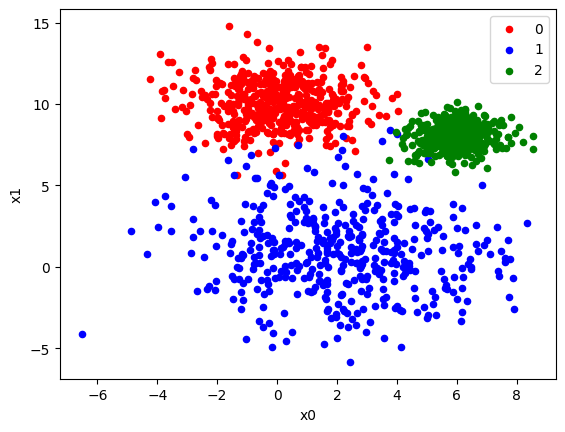

In [45]:
df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [46]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:06<00:00, 13.19it/s, Method=max, Rate=1.00]   


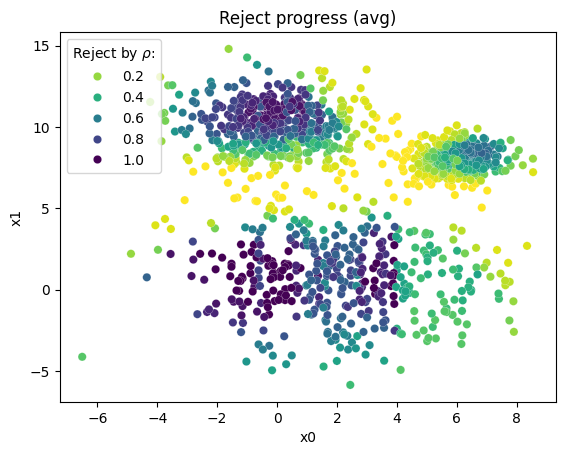

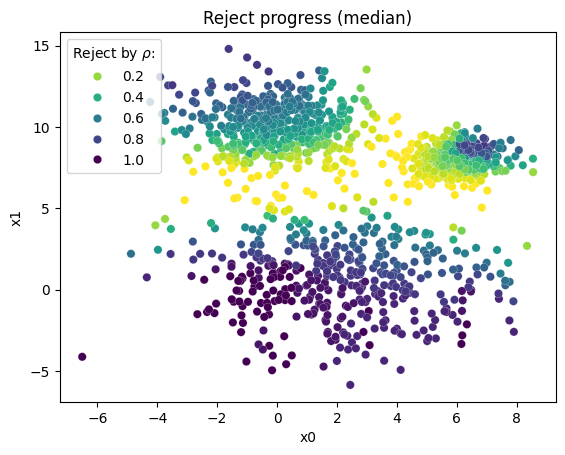

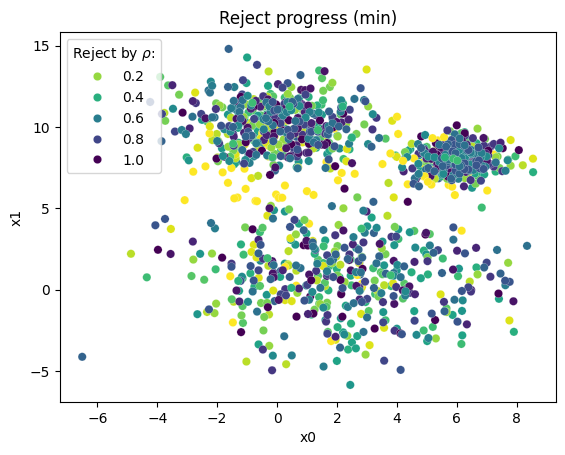

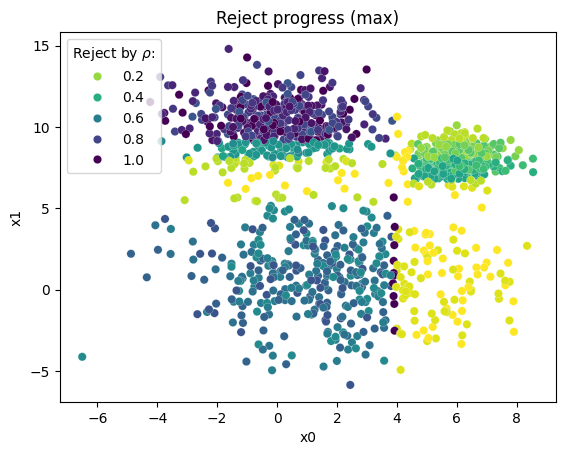

In [47]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

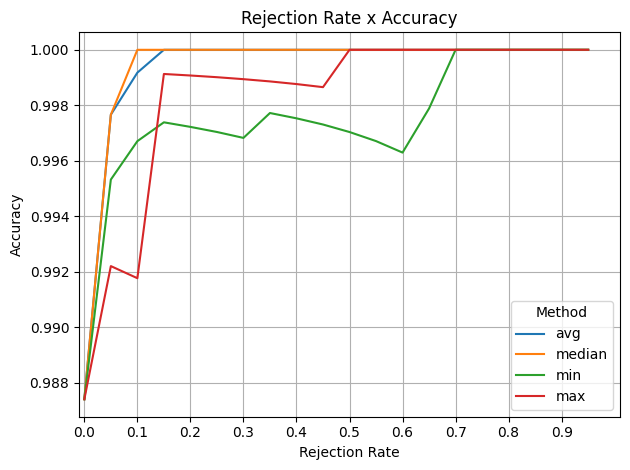

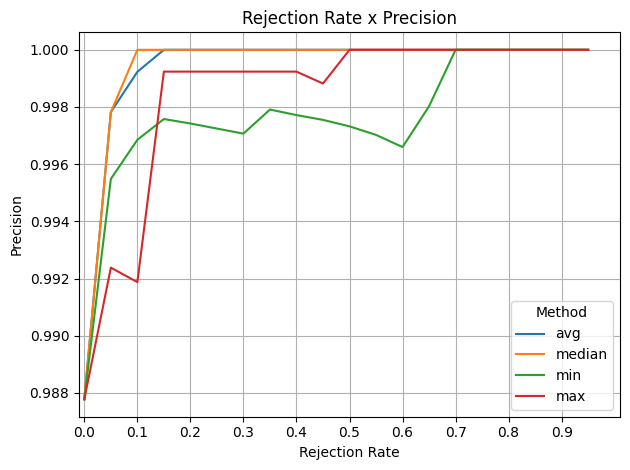

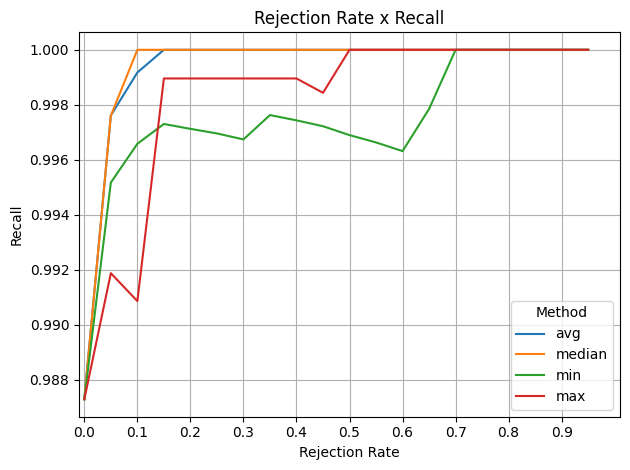

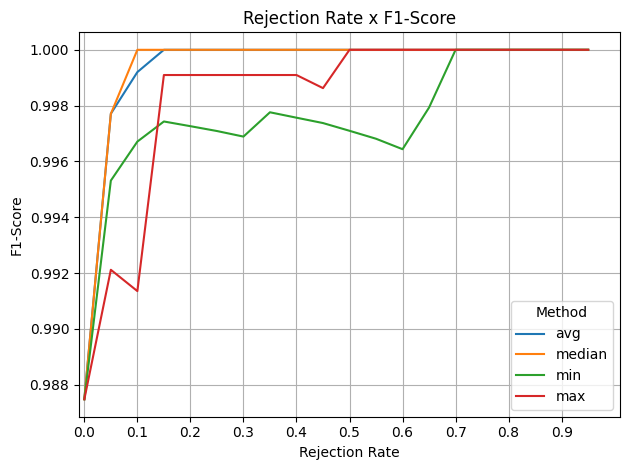

In [48]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [49]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.950
Method: median 	 |  Score: 0.950
Method: min 	 |  Score: 0.948
Method: max 	 |  Score: 0.949


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.987407   0.987777  0.987298  0.987479  0.949527
1     avg            0.05  0.997662   0.997821  0.997613  0.997709  0.949527
2     avg            0.10  0.999177   0.999230  0.999175  0.999202  0.949527
3     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.949527
4     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.949527
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  1.000000   1.000000  1.000000  1.000000  0.948506
76    max            0.80  1.000000   1.000000  1.000000  1.000000  0.948506
77    max            0.85  1.000000   1.000000  1.000000  1.000000  0.948506
78    max            0.90  1.000000   1.000000  1.000000  1.000000  0.948506
79    max            0.95  1.000000   1.000000  1.000000  1.000000  0.948506

[80 rows x 7 columns]

In [50]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# COVID

In [8]:
#from train_models import experiment_name
dataset_name = 'covid'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/160327225644704008', creation_time=1765759361362, experiment_id='160327225644704008', last_update_time=1765759361362, lifecycle_stage='active', name='covid_v2.5_1246495320', tags={}>

In [19]:
len(X_train) + len(X_val) + len(X_test)

660

In [9]:
models, metades = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
X_train, X_val, X_test, y_train, y_val, y_test, scaler = get_data(dataset_name)
pred_reject = Pool(models)

0c01620042354a50b39992df781c309d


a267d9dd490c4ea2b80cc2ea0b29ee8c


d665eb629ce349ecb0790874cbb45dce


b46b0753f928482494e8e9fe1cafb98d


c941ef8e1d994aa2909e8ef5e31e3c56


53b861d7ed9449d692e087b597c3ba1b


dcdb7dd6707f44338b5c16db34a7230c


6a7612f804394db2b1702fec35a99469


599712095e024687af0bb182355cb1e6


2f909f90070f4ee28860c5a6ec75a98a


f1ce296ca49c413f8179fa59e19dabb3


ca80ca1a5f244b65bcc564db9efcb11e


1b7977ddeb6e498ab2b8943e2dd986fd


In [10]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:01<00:00, 49.00it/s, Method=max, Rate=1.00]   


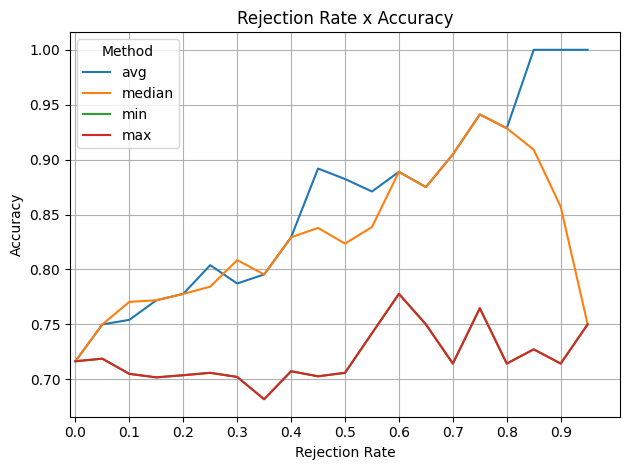

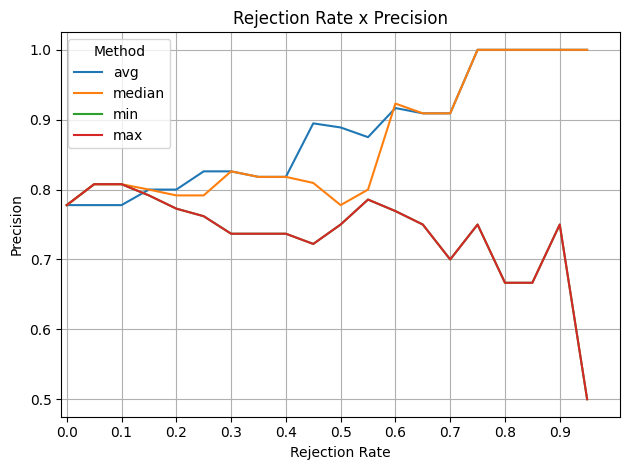

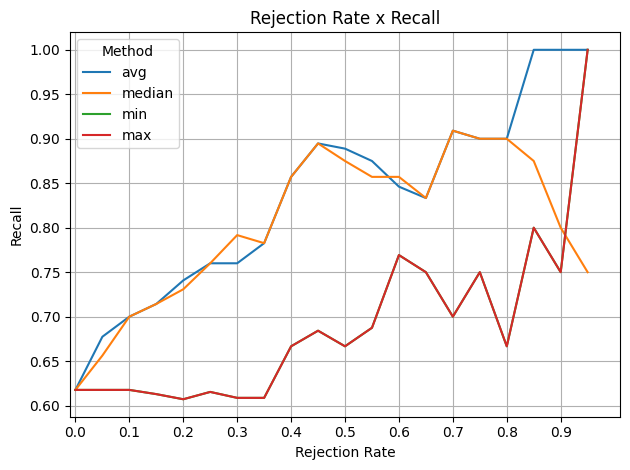

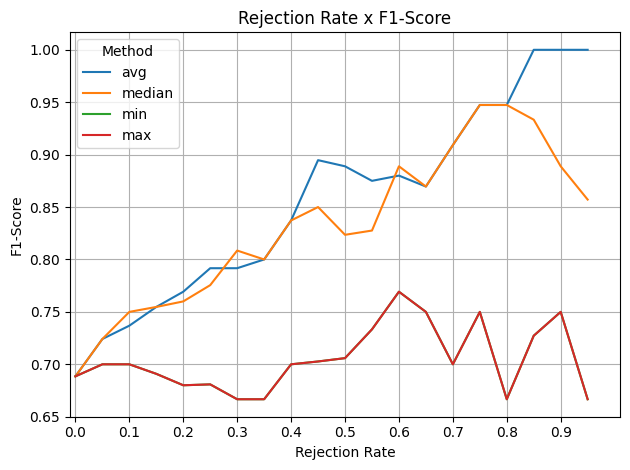

In [11]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [12]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.816
Method: median 	 |  Score: 0.791
Method: min 	 |  Score: 0.684
Method: max 	 |  Score: 0.684


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.716418   0.777778  0.617647  0.688525  0.815575
1     avg            0.05  0.750000   0.777778  0.677419  0.724138  0.815575
2     avg            0.10  0.754098   0.777778  0.700000  0.736842  0.815575
3     avg            0.15  0.771930   0.800000  0.714286  0.754717  0.815575
4     avg            0.20  0.777778   0.800000  0.740741  0.769231  0.815575
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.764706   0.750000  0.750000  0.750000  0.683631
76    max            0.80  0.714286   0.666667  0.666667  0.666667  0.683631
77    max            0.85  0.727273   0.666667  0.800000  0.727273  0.683631
78    max            0.90  0.714286   0.750000  0.750000  0.750000  0.683631
79    max            0.95  0.750000   0.500000  1.000000  0.666667  0.683631

[80 rows x 7 columns]

In [17]:
results_log, reject_history = rejection_plus_metades(pred_reject, metades,
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing:   0%|          | 0/84 [00:00<?, ?it/s]

Processing:   1%|          | 1/84 [00:00<00:14,  5.69it/s, Method=avg, Rate=0.00]


KeyError: '[nan] not in index'

In [57]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# HELOC

In [58]:
dataset_name = 'heloc'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/922033247023021820', creation_time=1764377843010, experiment_id='922033247023021820', last_update_time=1764377843010, lifecycle_stage='active', name='heloc_v1_1246495320', tags={}>

In [59]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

1d54546c1c3049c5b92fa3cc468357c8


ed04a84a7ed74aa68f9303392a24c055


63c260a94b7043cc952fd9bdb142d521


7416fc95ecb3432bbb342a01593de309


7765459f098646eb918a57071b6115e7


89acf8cac4e84da0af4de5bebce3f7fe


aa75eda2876f4899a538cd865c4053ce


76d252257405411bbb90c67212d751fc


d66bc514e5d0453a9f5fbac0dcb0c1ca


26a68ef937f349bc8a1a399377fa3b08


68afd1f9159d420c9e09a4070fc87cf2


d90fe1cb4cf845088c0bbde7a395063b


In [61]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:13<00:00,  6.21it/s, Method=max, Rate=1.00]   


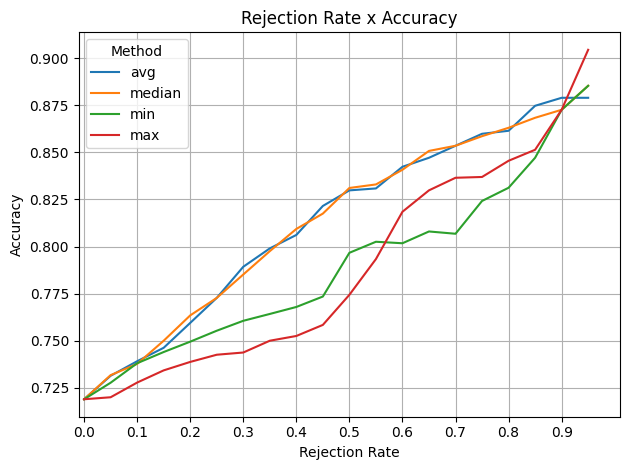

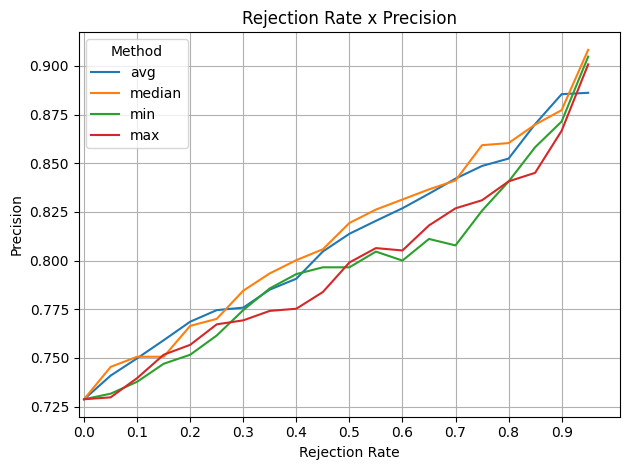

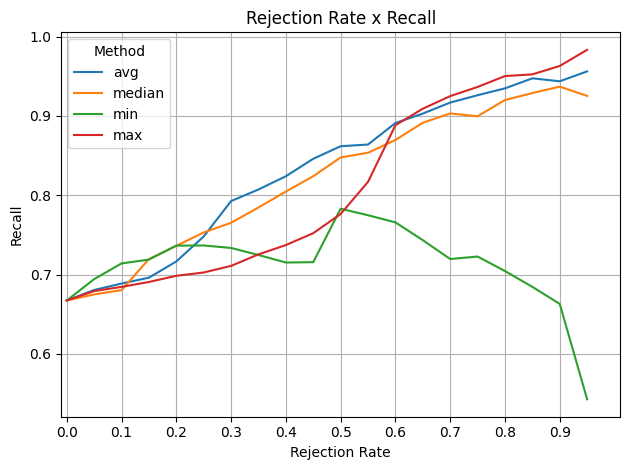

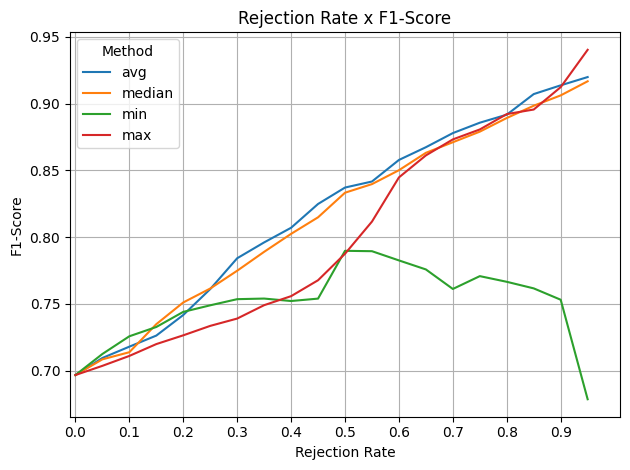

In [62]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [63]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.772
Method: median 	 |  Score: 0.772
Method: min 	 |  Score: 0.749
Method: max 	 |  Score: 0.747


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.718929   0.728777  0.667325  0.696699  0.772131
1     avg            0.05  0.731388   0.740909  0.680585  0.709467  0.772131
2     avg            0.10  0.739115   0.749800  0.688693  0.717949  0.772131
3     avg            0.15  0.746252   0.759087  0.696124  0.726243  0.772131
4     avg            0.20  0.759458   0.768617  0.716529  0.741660  0.772131
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.836943   0.830986  0.936508  0.880597  0.746937
76    max            0.80  0.845541   0.840671  0.950237  0.892102  0.746937
77    max            0.85  0.851380   0.845070  0.952381  0.895522  0.746937
78    max            0.90  0.872611   0.866667  0.962963  0.912281  0.746937
79    max            0.95  0.904459   0.900763  0.983333  0.940239  0.746937

[80 rows x 7 columns]

In [64]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# CHURN

In [65]:
dataset_name = 'churn'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/964677116734142252', creation_time=1764378762614, experiment_id='964677116734142252', last_update_time=1764378762614, lifecycle_stage='active', name='churn_v1_1246495320', tags={}>

In [66]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name)
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name)
pred_reject = Pool(models)

6c6a9c411a79402ab8ef12773387f0ac


852ae500c6b0444785653d527792a5c3


50c2f98f27ea43459412e6510d0e7c92


ccfaf56635044268a28d3268ca76b219


7484cae68ffd495698b9a7e04389e700


c65d6229d5764a5bb1e5dc17c6c456d9


efd6b7c0c45d4138be087475c0dbfdbd


f9cde064949147b4a11ece2957133a88


0be4f6f4f9a74157857c7f3d961d49f9


5a116622d2a545c48456d74f155426e5


9e7b788716da4815b526bd5f643a9645


ccec6d94570f4efd991ab1ff651f3163


In [67]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [00:10<00:00,  7.84it/s, Method=max, Rate=1.00]   


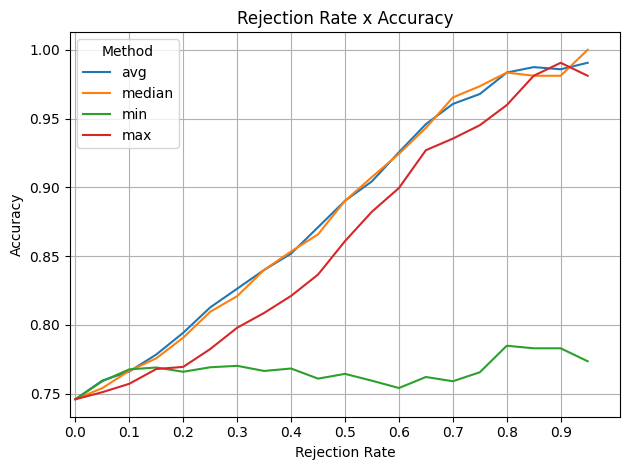

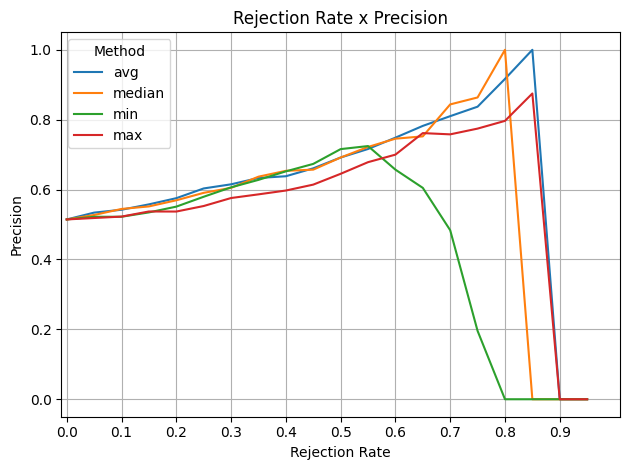

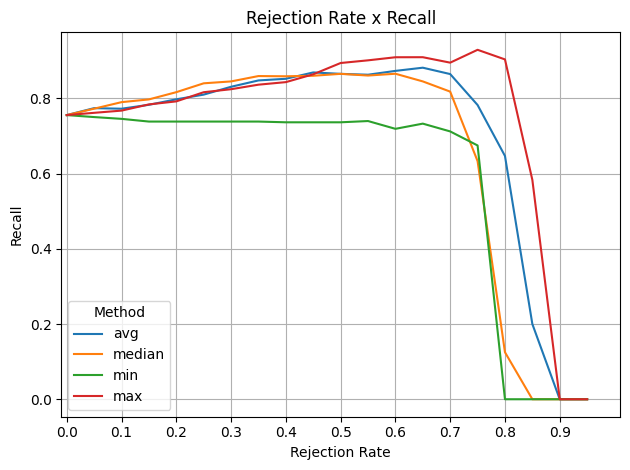

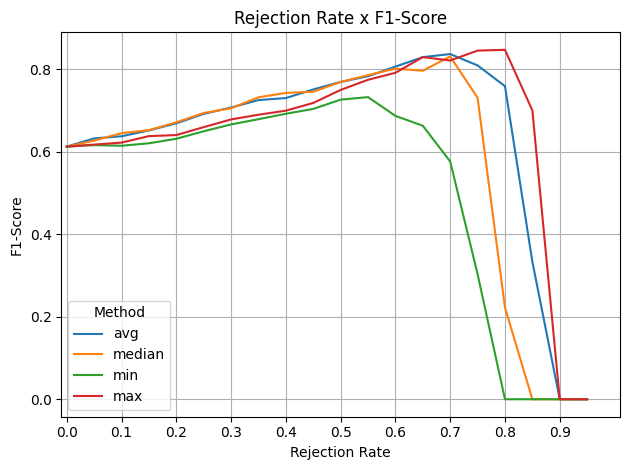

In [68]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [69]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.836
Method: median 	 |  Score: 0.835
Method: min 	 |  Score: 0.729
Method: max 	 |  Score: 0.817


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.00  0.745979   0.514563  0.755793  0.612274  0.836009
1     avg            0.05  0.759582   0.534106  0.774254  0.632140  0.836009
2     avg            0.10  0.766159   0.542302  0.772727  0.637327  0.836009
3     avg            0.15  0.778520   0.557721  0.783158  0.651489  0.836009
4     avg            0.20  0.794326   0.575410  0.797727  0.668571  0.836009
..    ...             ...       ...        ...       ...       ...       ...
75    max            0.75  0.945180   0.774510  0.929412  0.844920  0.816911
76    max            0.80  0.959811   0.796610  0.903846  0.846847  0.816911
77    max            0.85  0.981132   0.875000  0.583333  0.700000  0.816911
78    max            0.90  0.990566   0.000000  0.000000  0.000000  0.816911
79    max            0.95  0.981132   0.000000  0.000000  0.000000  0.816911

[80 rows x 7 columns]

In [70]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')

# COVER TYPE

In [71]:
dataset_name = 'covertype'
experiment_name = getExpName(dataset_name)
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/209727873322380469', creation_time=1764379333318, experiment_id='209727873322380469', last_update_time=1764379333318, lifecycle_stage='active', name='covertype_v1_1246495320', tags={}>

In [72]:
models = searchAndTrain(experiment_name=experiment_name, num_trials=20, load=True, dataset=dataset_name) 
X_train, X_test, y_train, y_test, scaler = get_data(dataset_name) 
pred_reject = Pool(models)

03f00690c8904a24a5d0511e13c5260f


08618eeeaf6740ec9df6500476a7ed72


6c4c33ad91a24415b6fe8cf6f2262e77


8e2dec28645148629e2858351c854f4c


c28f16da7da3410f82a8630b64bb2be1


8ec6640d00354df4966f7bdb297f36ac


56edb4396c6141c4bfc2af1de9367e57


c4071e8842d84e33911dca4f01390b6d


66bd34a873e943b0986fcc7a23a3b8ec


64dcdbd2e9bd457988aaf3549221e76e


64d1ee5c2137417799a095e181d5f6a9


2793d42d9fe142a68cec29035c5be482


In [73]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 y_test.values,
                                                 rej_rates=rates_array,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 84/84 [02:34<00:00,  1.84s/it, Method=max, Rate=1.00]   


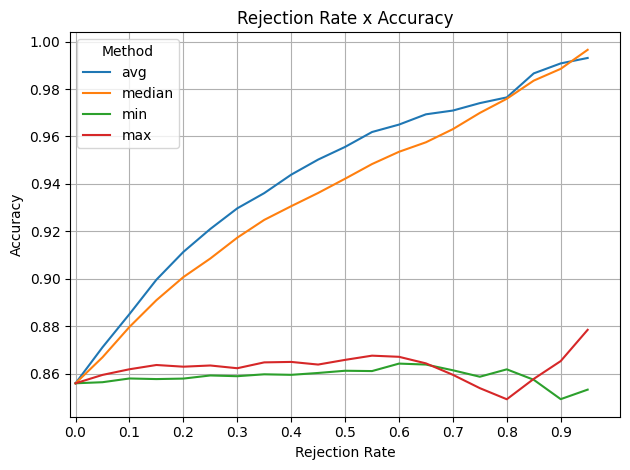

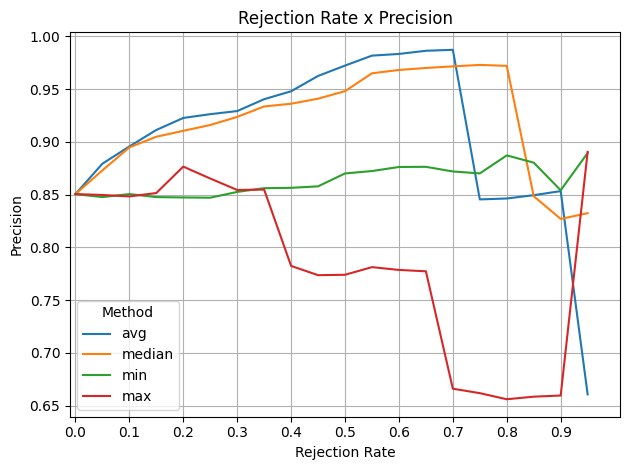

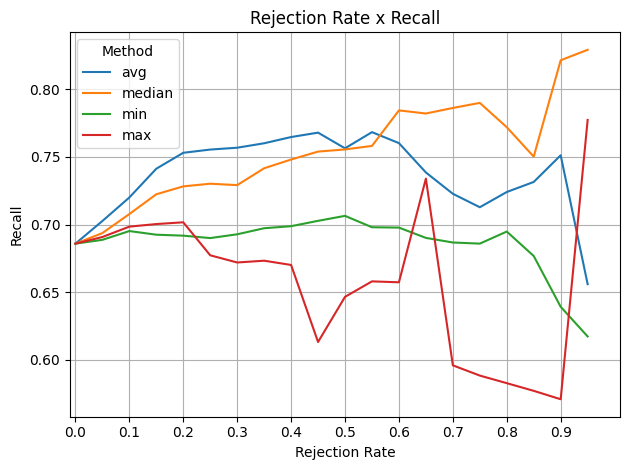

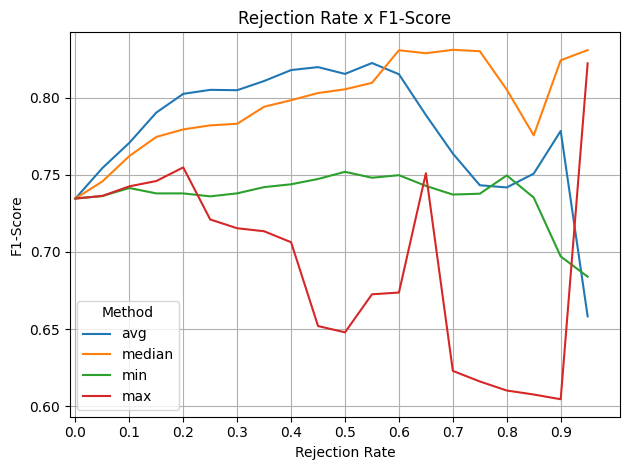

In [74]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [75]:
for method in ['avg','median','min','max']:
    score = auc(x=rates_array,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.896
Method: median 	 |  Score: 0.888
Method: min 	 |  Score: 0.816
Method: max 	 |  Score: 0.819


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score   AU-ARC
0     avg            0.00  0.855889   0.850573  0.685886  0.734598  0.89616
1     avg            0.05  0.871075   0.879376  0.702601  0.754336  0.89616
2     avg            0.10  0.885071   0.895734  0.719968  0.770674  0.89616
3     avg            0.15  0.899575   0.911346  0.741223  0.790249  0.89616
4     avg            0.20  0.911294   0.922758  0.752989  0.802401  0.89616
..    ...             ...       ...        ...       ...       ...      ...
75    max            0.75  0.853832   0.661866  0.588436  0.616121  0.81920
76    max            0.80  0.849154   0.656086  0.582839  0.610238  0.81920
77    max            0.85  0.857744   0.658531  0.577163  0.607660  0.81920
78    max            0.90  0.865252   0.659619  0.570954  0.604590  0.81920
79    max            0.95  0.878440   0.890630  0.777245  0.822155  0.81920

[80 rows x 7 columns]

In [76]:
results_log.to_csv(f'results/{dataset_name}_{CONFIG["VERSION"]}.csv')